In [205]:
import requests
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [206]:
data = pd.read_csv('accidents.csv', header = None)

In [207]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,56a72710-563d-410e-a744-468d2421092e,"Forecaster, CAIC",2/20/2018 7:00,Known,Estimated,38.008880,-107.873070,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""Convex Slope""}"
1,6e872258-f60c-47bb-b6eb-484cc0fe3e89,"Forecaster, CAIC",12/19/2024 19:00,Estimated,Unknown,39.682316,-105.930845,f,f,t,...,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{}
2,22315e1b-b4cf-4de4-9c1b-9a3d124db2d4,"Forecaster, CAIC",1/22/2012 19:00,Known,Unknown,40.506490,-105.886230,f,f,t,...,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{}
3,4cc8fd48-c67f-40c3-963f-1c3bbed8676b,"Forecaster, CAIC",1/22/2012 7:00,Known,Unknown,39.886920,-105.760660,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50f496f8-21d1-4a6f-a250-8b7c821810c1,"Forecaster, CAIC",1/14/2018 19:00,Known,Unknown,38.689060,-106.355380,f,f,t,...,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{}


In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 89 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       308 non-null    object 
 1   1       296 non-null    object 
 2   2       308 non-null    object 
 3   3       308 non-null    object 
 4   4       294 non-null    object 
 5   5       308 non-null    float64
 6   6       308 non-null    float64
 7   7       42 non-null     object 
 8   8       42 non-null     object 
 9   9       42 non-null     object 
 10  10      308 non-null    object 
 11  11      200 non-null    object 
 12  12      109 non-null    object 
 13  13      308 non-null    object 
 14  14      308 non-null    int64  
 15  15      199 non-null    object 
 16  16      213 non-null    object 
 17  17      308 non-null    object 
 18  18      20 non-null     float64
 19  19      256 non-null    object 
 20  20      285 non-null    object 
 21  21      12 non-null     object 
 22  22

In [209]:
#I used excel to identify the columns worth keeping, then converted their column letters into array positions
#I will keep these columns
cols_to_keep = [2, 5, 6, 19, 20, 30, 46]

avalanche_df = data[cols_to_keep]

#Now we should have the unique accident ID, date, latitude, longitude, avalanche type, aspect, elevation, and slope degree
avalanche_df.head()

,2,5,6,19,20,30,46
0,2/20/2018 7:00,38.008880,-107.873070,HS,N,11400.0,NaN
1,12/19/2024 19:00,39.682316,-105.930845,NaN,W,11600.0,NaN
2,1/22/2012 19:00,40.506490,-105.886230,NaN,NaN,NaN,NaN
3,1/22/2012 7:00,39.886920,-105.760660,NaN,N,10400.0,NaN
4,1/14/2018 19:00,38.689060,-106.355380,SS,NE,11200.0,35.0


In [210]:
#Now I'll name the columns that we want to keep
avalanche_df.columns = ['Date','Latitude','Longitude','Avalanche Type','Aspect','Elevation','Slope Degree']

In [211]:
#Lets check and see how it looks with the column names
avalanche_df.head()

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree
0,2/20/2018 7:00,38.008880,-107.873070,HS,N,11400.0,NaN
1,12/19/2024 19:00,39.682316,-105.930845,NaN,W,11600.0,NaN
2,1/22/2012 19:00,40.506490,-105.886230,NaN,NaN,NaN,NaN
3,1/22/2012 7:00,39.886920,-105.760660,NaN,N,10400.0,NaN
4,1/14/2018 19:00,38.689060,-106.355380,SS,NE,11200.0,35.0


In [212]:
#Lets see how many Avalanche Types (the Y of our model) we are missing
avalanche_df['Avalanche Type'].isna().sum()

52

In [213]:
#Lets compare that to how many non-nan values we have
avalanche_df['Avalanche Type'].count()

256

In [214]:
#And then the total length of the column
len(avalanche_df['Avalanche Type'])

308

In [215]:
#We cannot impute, guess, or leave missing values in the target values unfortunately. This would break the training process of the model. 
#For the sake of this project, I will need to drop the 50 missing rows.
avalanche_df = avalanche_df.dropna(subset = ['Avalanche Type'])


In [216]:
#Next, lets check for duplicate values, the CAIC warned there may be duplicate values reported for avalanche accidents.
#We will start by checking for total duplicate values in the list. Accidents with the same latitude, longitude, and time would be guaranteed duplicates
#So we will remove those. 
duplicates = avalanche_df[avalanche_df.duplicated(['Date','Latitude','Longitude'], keep = False)]
duplicates

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree
156,1/17/2019 7:00,38.808250,-106.413350,SS,E,12000.0,40.0
184,2/22/2025 19:00,39.800478,-105.772558,HS,NW,11470.0,NaN
198,1/17/2019 7:00,38.808250,-106.413350,SS,E,12000.0,40.0
219,2/22/2025 19:00,39.800478,-105.772558,HS,NW,NaN,NaN


In [217]:
#We have two duplicate avalanche accidents reported. Let's remove one.
avalanche_df = avalanche_df.drop_duplicates(['Date','Latitude','Longitude'],keep = False)

In [218]:
#And now I'll check again that it worked:
duplicates = avalanche_df[avalanche_df.duplicated(keep = False)]
duplicates

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree


<Axes: >

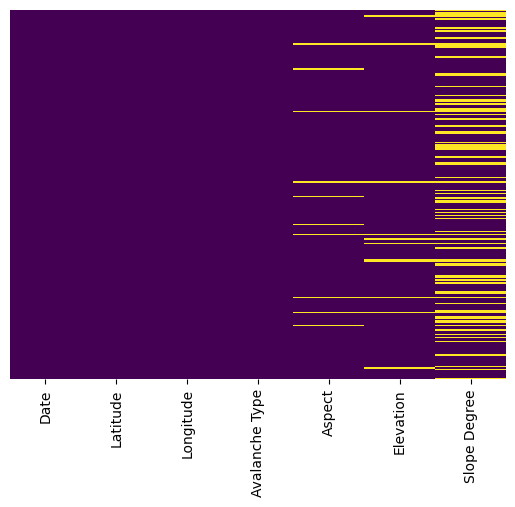

In [219]:
#I like to use this trick to visualize how much missing data we have. It looks like theres a lot of missing slope degree and some missing
#Data from other data types. Thankfully there are no missing dates, latitudes, or longitudes so I think we can feature engineer and fill these in
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [220]:
#I'm going to focus on getting elevation sorted out first. Let me get familiar with elevation

<Axes: ylabel='Elevation'>

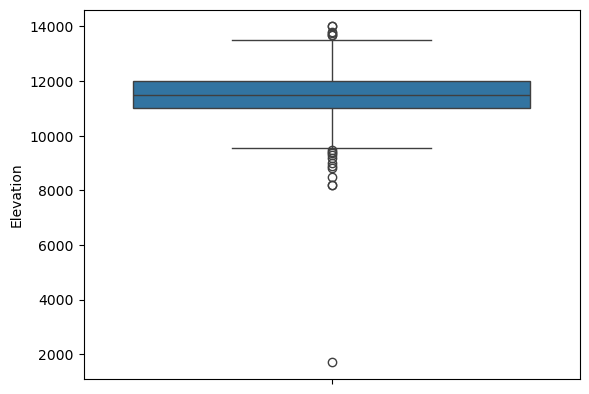

In [221]:
sns.boxplot(avalanche_df, y = 'Elevation')

In [222]:
#It appears the majority of avalanche accidents occur between 11,000 and 12,000 ft which makes sense, that is the majority of the peak elevations 
#within colorado.

In [223]:
#Let me find the < 2000ft outlier. Colorado is generally a minimum of 5280ft so 1700ft doesn't make sense.
avalanche_df['Elevation'].min()

1700.0

In [224]:
#Lets drop that row
avalanche_df = avalanche_df.drop(avalanche_df['Elevation'].idxmin())

In [225]:
#Now check our minimum
avalanche_df['Elevation'].min()

8200.0

In [226]:
#That seems more inline with avalanche elevations

In [227]:
#I found Elevation API that can extract Elevation from latitude and longitude. I'm going to try to use it:

def get_elevation(lat, lon):
    url = 'https://api.open-elevation.com/api/v1/lookup'
    params = {'locations': f'{lat},{lon}'}
    response = requests.get(url, params=params).json()
    elevation_meters = response['results'][0]['elevation']
    return elevation_meters * 3.28084

In [228]:
#Lets test it against an elevation we know. I will use row 1. 
get_elevation(39.682316, -105.930845)

11630.5778

In [229]:
#It gave us an elevation of 11,630 and our target elevation was 11,600!
#lets run it again on another test point to check it
get_elevation(38.008880, -107.873070)

11994.75104

In [230]:
#Not quite as accurate, it should have been 11,400ft. The free API may not have the highest resolution but it is relatively close
#and is also a free api. For the sake of this project is should work.

In [231]:
#Lets make a function to fill the 52 missing elevation values. I hope this works with their API
def fill_elevation(row):
    if np.isnan(row['Elevation']):
        return get_elevation(row['Latitude'], row['Longitude'])
    else:
        return row['Elevation']

avalanche_df['Elevation'] = avalanche_df.apply(fill_elevation, axis = 1)
        

In [232]:
#It looks like it worked, it filled in the missing values
avalanche_df.head()

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree
0,2/20/2018 7:00,38.00888,-107.87307,HS,N,11400.00000,NaN
4,1/14/2018 19:00,38.68906,-106.35538,SS,NE,11200.00000,35.0
6,3/12/2010 7:00,38.32872,-106.23696,SS,W,12000.00000,NaN
7,3/7/2019 7:00,39.49174,-106.11663,HS,W,11900.00000,NaN
8,11/24/2013 17:30,39.83408,-105.64865,SS,E,11194.22608,NaN


<Axes: >

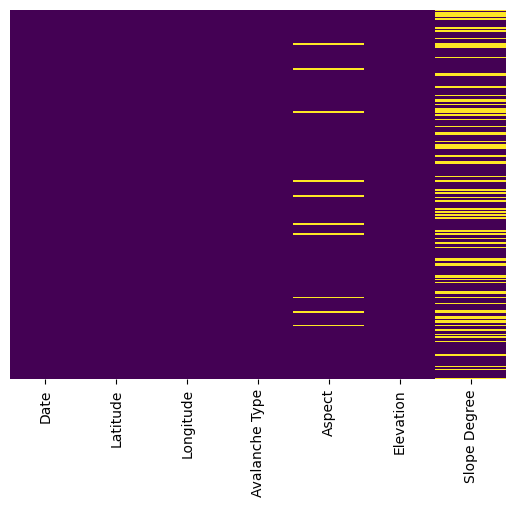

In [233]:
#Lets check
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

<Axes: ylabel='Elevation'>

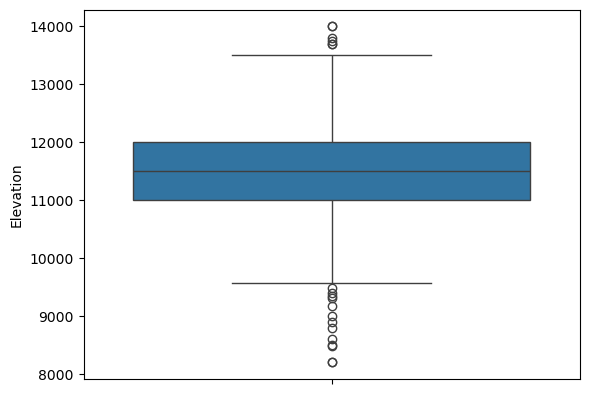

In [234]:
#And then lets check that it actually filled them in and kept our distribution
sns.boxplot(avalanche_df, y = 'Elevation')

In [235]:
#Great, now the last thing to do with the elevation column is set it's data type to integer
avalanche_df['Elevation'] = avalanche_df['Elevation'].astype(int)

In [236]:
#We have a lot of missing Slope Degree data. Slope degree is critical to the probability of an avalanche occurring and what type of avalanche
#may occur so we need to keep this row if we can. 
#I made detailed notes in my log about this, but most avalanches occur between 30 and 45 degrees according to online sources. Let's
#visualize the avalanche slope degrees and see where they are most commonly occuring in our data set.

#It looks like the maximum value of the column is an incorrectly entered slope degree. This was likely meant to be 35 degrees. I am
#going to set it to 35.
print(avalanche_df['Slope Degree'].dropna().max())

355.0


In [237]:
avalanche_df.loc[avalanche_df['Slope Degree'] == 355.0, 'Slope Degree'] = 35.0

In [238]:
print(avalanche_df['Slope Degree'].dropna().max())

50.0


In [239]:
#Great that is a much more reasonable maximum and lies within the range my research showed would be a reasonable max avalanche slope.

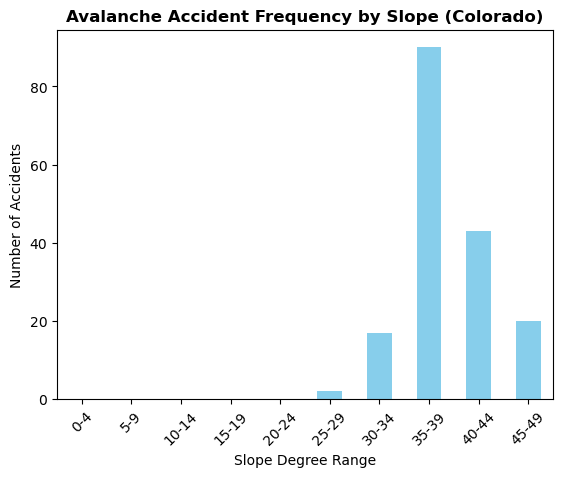

In [240]:
#Ok so now I'll make the bins to visualize where most common avalanches are occuring.

maximum_slope_degree = int(avalanche_df['Slope Degree'].dropna().max())

bins = range(0, maximum_slope_degree + 5, 5) #Create bins in groups of 5 degrees to see where the most avalanches occur.
labels = [f"{d}-{d+4}" for d in bins[:-1]] #Make labels for each of the bins giving a range of degrees in 5 degree increments
bin_df = pd.DataFrame() #I chose to make a separate data frame for this visualization
bin_df['Slope Bin'] = pd.cut(avalanche_df['Slope Degree'].dropna(), bins = bins, labels = labels, right = False) 

bin_counts = bin_df['Slope Bin'].value_counts().sort_index()
bin_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Slope Degree Range')
plt.ylabel('Number of Accidents')
plt.title('Avalanche Accident Frequency by Slope (Colorado)', fontweight = 'bold')
plt.xticks(rotation=45)
plt.show()

In [241]:
#Next let's look at what percent of the data each slope degree bin contributes to. I think this could be used
#To make a weighted distribution for filling in missing values
bin_percentages = (bin_counts / bin_counts.sum()) *100
bin_percentages.round(2)

Slope Bin
0-4       0.00
5-9       0.00
10-14     0.00
15-19     0.00
20-24     0.00
25-29     1.16
30-34     9.88
35-39    52.33
40-44    25.00
45-49    11.63
Name: count, dtype: float64

In [242]:
#So what I'll do is create weights from these numbers and also drop any that are 0
bin_weights = bin_percentages / 100
actual_bins = bin_weights[bin_weights > 0] 
actual_bins

Slope Bin
25-29    0.011628
30-34    0.098837
35-39    0.523256
40-44    0.250000
45-49    0.116279
Name: count, dtype: float64

In [243]:
#Alright! Looks like that should work.


#Map the bin labels to numeric range
bin_ranges = {
    '25-29' : (25,29),
    '30-34' : (30, 34),
    '35-39' : (35, 39),
    '40-44' : (40, 44),
    '45-49' : (45, 49)
}

def fill_slope_from_bins(n):
    
    #Make a list of bin labels
    bins = actual_bins.index.tolist() 

    #Get the probability associated with each bin
    degree_probs = actual_bins.values

    #Randomly select n bin labels given the probability of each bin
    selected_bins = np.random.choice(bins, size = n, p = degree_probs)

    #Then for each bin label, draw a random slope degree within that bins range 
    return [
        np.random.uniform(*bin_ranges[bin_label]) #Unpacks the bin range tuple and get a random slope degree within that bin range
        for bin_label in selected_bins
    ]

missing_index = avalanche_df['Slope Degree'].isnull()
avalanche_df.loc[missing_index, 'Slope Degree'] = fill_slope_from_bins(missing_index.sum())

In [244]:
#I'm going to check and see if we have any null values still.
avalanche_df[avalanche_df['Slope Degree'].isnull()]

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree


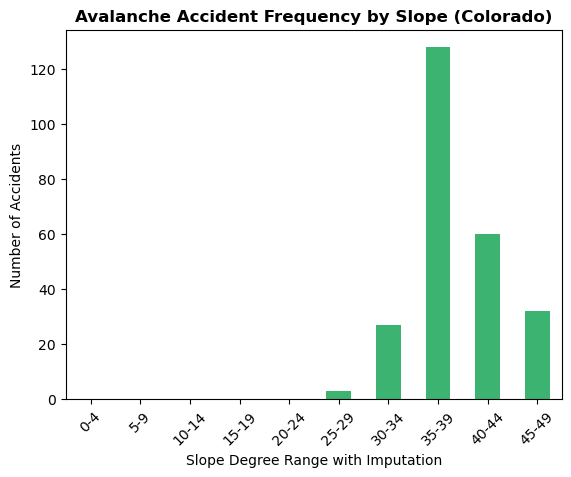

In [245]:
#So now we can look visualize the slope degree distirbution again with a bar plot and make sure we visually follow the 
#same distribution

maximum_slope_degree = int(avalanche_df['Slope Degree'].max())

bins = range(0, maximum_slope_degree + 5, 5)
labels = [f"{d}-{d+4}" for d in bins[:-1]]

bin_df_imputed = pd.DataFrame()
bin_df_imputed['Slope Bin'] = pd.cut(avalanche_df['Slope Degree'], bins = bins, labels = labels, right = False) 
bin_counts_imputed = bin_df_imputed['Slope Bin'].value_counts().sort_index()

bin_counts_imputed.plot(kind='bar', color='mediumseagreen')
plt.xlabel('Slope Degree Range with Imputation')
plt.ylabel('Number of Accidents')
plt.title('Avalanche Accident Frequency by Slope (Colorado)', fontweight = 'bold')
plt.xticks(rotation=45)
plt.show()

In [246]:
#It looks like we kept the overall shape but with much more data points and now we have no missing slope degree values

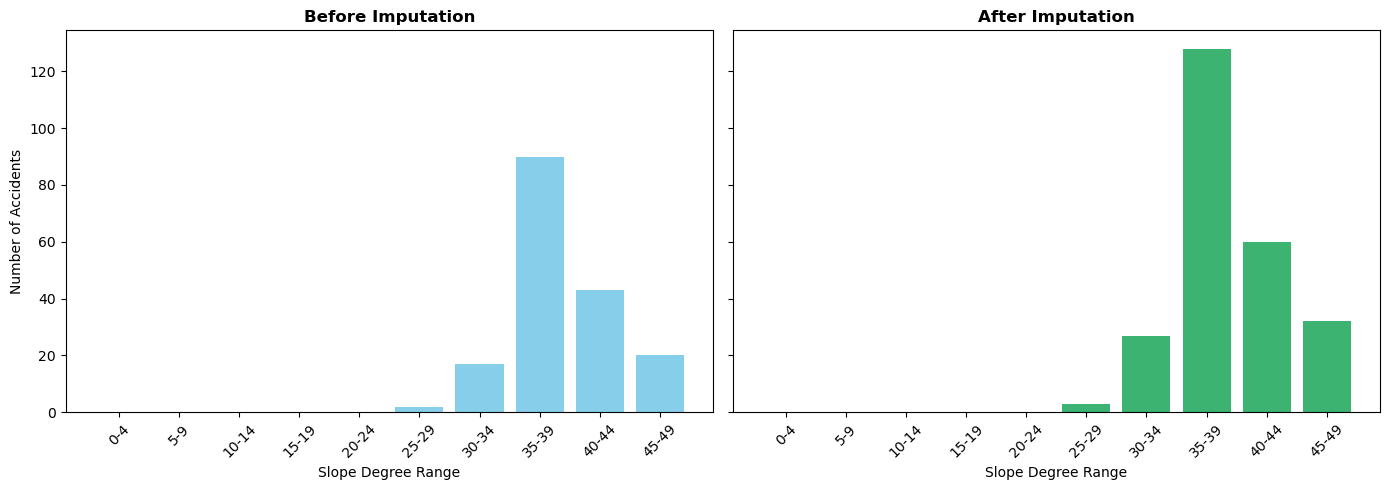

In [247]:
#Lets look at them side by side!
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

#Plot the before imputation
axes[0].bar(labels, bin_counts.values, color='skyblue')
axes[0].set_title('Before Imputation', fontweight='bold')
axes[0].set_xlabel('Slope Degree Range')
axes[0].set_ylabel('Number of Accidents')
axes[0].tick_params(axis='x', rotation=45)

#Plot the after imputation 
axes[1].bar(labels, bin_counts_imputed.values, color='mediumseagreen')
axes[1].set_title('After Imputation', fontweight='bold')
axes[1].set_xlabel('Slope Degree Range')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [248]:
#This is great, we've kept the same distribution of the data but increased our usable data significantly!

<Axes: >

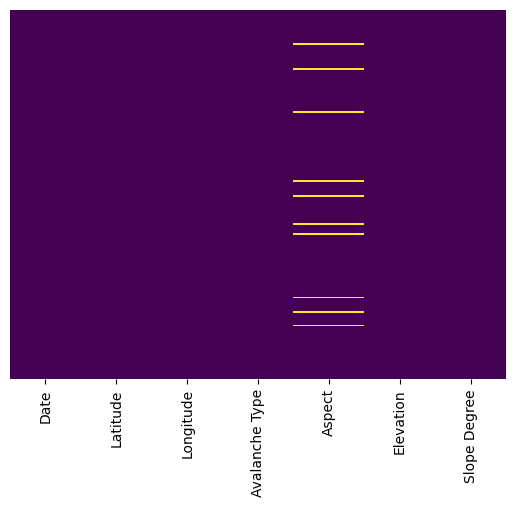

In [249]:
#Lets check where we're at on missing data
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [250]:
#Lets see what percentage of the data each aspect accounts for:

aspect_count = avalanche_df['Aspect'].value_counts()
aspect_pcnt = aspect_count / aspect_count.sum()
aspect_pcnt

Aspect
NE    0.228216
E     0.186722
N     0.161826
NW    0.145228
SE    0.120332
W     0.074689
S     0.070539
SW    0.012448
Name: count, dtype: float64

In [251]:
aspects = aspect_pcnt.index.tolist()

#Get a list of the weights
aspect_probs = aspect_pcnt.values

#Find how many missing values we have - should be 10
number_missing = avalanche_df['Aspect'].isna().sum()

#Now randomly select the weighted aspect
aspects_imputed = np.random.choice(aspects, size = number_missing, p = aspect_probs)

#Now replace the missing indexes in the dataframe with the weightedimputed values
avalanche_df.loc[avalanche_df['Aspect'].isna(), 'Aspect'] = aspects_imputed

<Axes: >

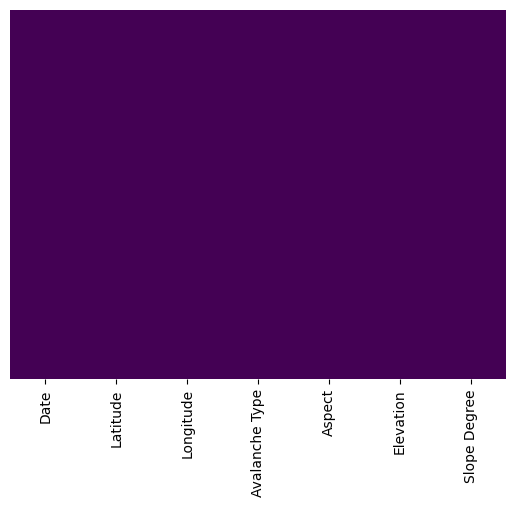

In [252]:
#Lets check now where we're at with missing data
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [253]:
#Sweet! No missing data. Now I'll break date down into time of day and time of season

In [254]:
avalanche_df['Date'] = pd.to_datetime(avalanche_df['Date'])

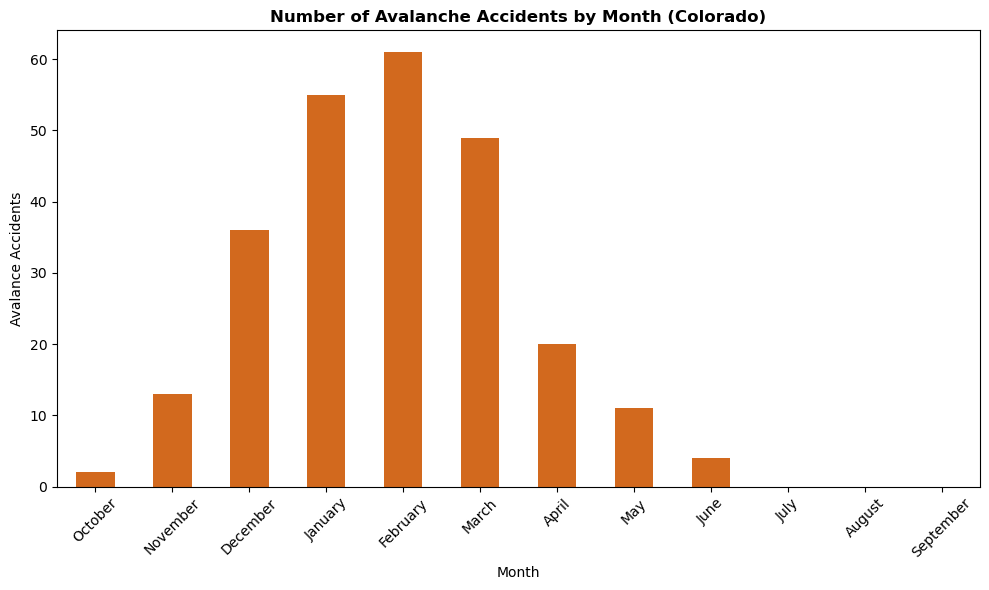

In [255]:
month_df = pd.DataFrame()
month_df['Month'] = avalanche_df['Date'].dt.month_name()

#Count avalanche accidents by month. I'm re-indexing in order from where we would consider the start of the season onwards.
monthly_counts = month_df['Month'].value_counts().reindex([
    'October', 'November', 'December', 'January', 'February', 'March',
    'April', 'May', 'June', 'July', 'August', 'September'
])

monthly_counts.plot(kind='bar', figsize=(10, 6), color='chocolate')
plt.xlabel('Month')
plt.ylabel('Avalance Accidents')
plt.title('Number of Avalanche Accidents by Month (Colorado)', fontweight='bold')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

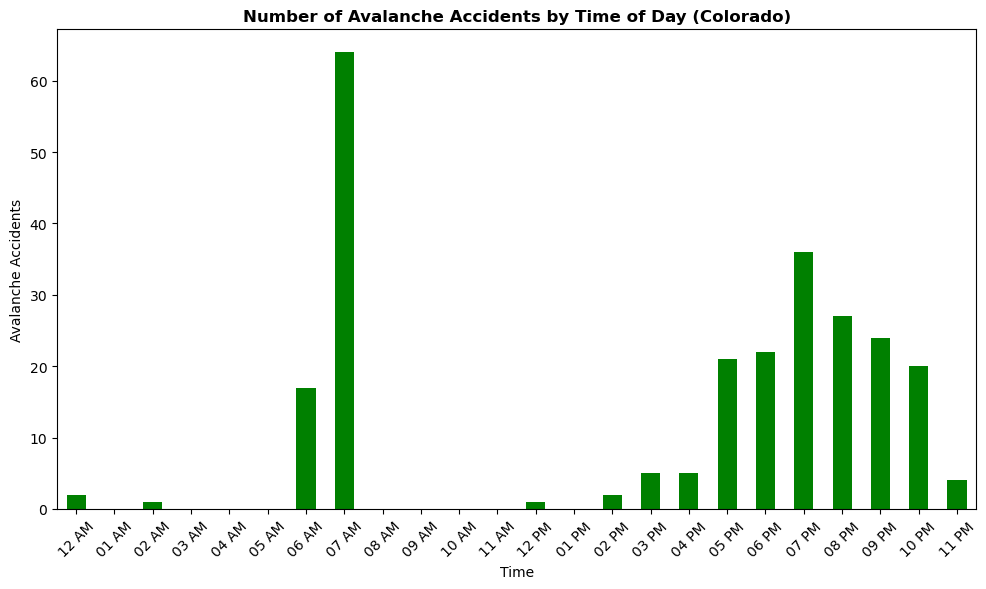

In [256]:
time_df = pd.DataFrame()
time_df['Hour'] = avalanche_df['Date'].dt.strftime('%I %p')

#Set the correct orders for the times (earliest to latest)
hour_order = pd.date_range("00:00", "23:00", freq="h").strftime('%I %p').unique()

#Count the number of accidents reported per hour and sort using the hour order
hour_counts = time_df['Hour'].value_counts().reindex(hour_order, fill_value=0)

#Plot the accidents by the hour from earliest to latest
hour_counts.plot(kind='bar', figsize=(10, 6), color='green')
plt.xlabel('Time')
plt.ylabel('Avalanche Accidents')
plt.title('Number of Avalanche Accidents by Time of Day (Colorado)', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [257]:
#Interesting!! It looks like time won't be helpful. It's likeley that this is the time the avalanche was recorded, not the time 
#of the incident. The CAIC often reports avalanches on the same day of the event, so it makes sense the majority of avalanche
#accidents time stamps are in the evening. We won't use time as a feature like I originally thought we could.

In [258]:
#I'll write a function to categorize the month into season
def categorize_season(date):
    month = date.month
    if month in [11,12]: #November to December (Early Season)
        return "Early Season"
    elif month in [1,2]: #January to February (Mid Season)
        return "Mid Season"
    elif month in [3,4]: #March to April (Late Season)
        return "Late Season"
    else:
        return "Off Season"

avalanche_df['Season'] = avalanche_df['Date'].apply(categorize_season)

<Axes: xlabel='Season'>

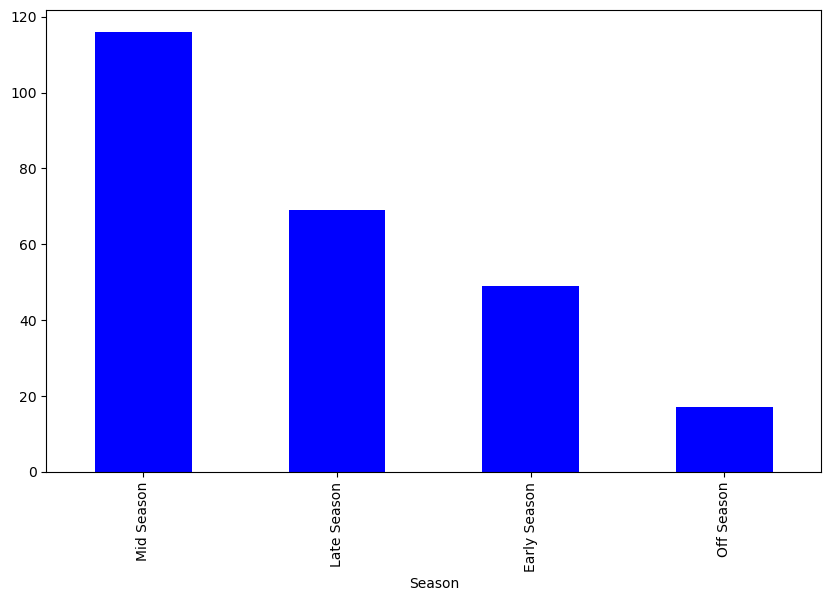

In [259]:
#We can create another visualization and see that the majority of avalanches occurred mid-season, with late season being more likely
#and early / off season being the least accidents. This is inline with my experience as a skier.
avalanche_df['Season'].value_counts().plot(kind='bar', figsize=(10, 6), color='blue')

In [260]:
#And move Season to be the first column. It just makes sense to me.
season_col = avalanche_df.pop('Season')  # Remove the column and save it
avalanche_df.insert(1, 'Season', season_col)  # Insert it at position 0 (first column)

In [261]:
print(avalanche_df.dtypes)

Date              datetime64[ns]
Season                    object
Latitude                 float64
Longitude                float64
Avalanche Type            object
Aspect                    object
Elevation                  int64
Slope Degree             float64
dtype: object


In [262]:
avalanche_df['Season'].unique()

array(['Mid Season', 'Late Season', 'Early Season', 'Off Season'],
      dtype=object)

In [263]:
avalanche_df['Avalanche Type'].unique()

array(['HS', 'SS', 'WL', 'WS', 'U', 'I', 'R', 'L', 'C'], dtype=object)

In [264]:
avalanche_df['Aspect'].unique()


array(['N', 'NE', 'W', 'E', 'NW', 'S', 'SE', 'SW'], dtype=object)

In [265]:
avalanche_df.columns

Index(['Date', 'Season', 'Latitude', 'Longitude', 'Avalanche Type', 'Aspect',
       'Elevation', 'Slope Degree'],
      dtype='object')

<Axes: xlabel='Avalanche Type'>

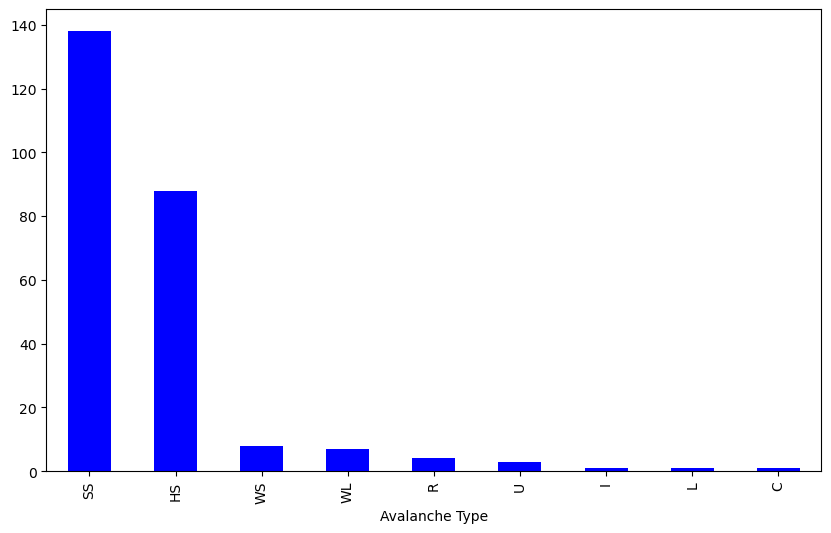

In [266]:
avalanche_df['Avalanche Type'].value_counts().plot(kind='bar', figsize=(10, 6), color='blue')

In [267]:
print(avalanche_df['Avalanche Type'].value_counts())

Avalanche Type
SS    138
HS     88
WS      8
WL      7
R       4
U       3
I       1
L       1
C       1
Name: count, dtype: int64


In [268]:
#Now I will filter the avalanche dataframe to only the avalanche type I want to keep for my model
avalanche_df = avalanche_df[avalanche_df['Avalanche Type'].isin(['SS', 'HS', 'WS', 'WL'])]

In [269]:
#And now we can see that we successfully dropped the rows that contain the unwanted avalanche types
#This is still obviously imbalanced! 
print(avalanche_df['Avalanche Type'].value_counts())

Avalanche Type
SS    138
HS     88
WS      8
WL      7
Name: count, dtype: int64


In [270]:
#I'll reset the index now 
avalanche_df.reset_index(drop=True, inplace=True)

In [271]:
#We now have 241 rows of data to use.
len(avalanche_df)

241

In [272]:
#I'm now going to try to use Open Meteo API to pull historical weather data.
#Developed with assistance from Open Meteo documentation and ChatGPT


#Converts the list of degrees into a single average direction for 72 hour weather window
def circular_mean(values):
    #Coerce the list of numbers and drop nan
    vals = pd.to_numeric(pd.Series(values), errors = 'coerce').dropna().to_numpy()

    if vals.size == 0:
        return None
    else:
        #Convert list to radians
        radians = np.deg2rad(vals)

        #Find mean sin and cos 
        sin = np.sin(radians).mean()
        cos = np.cos(radians).mean()

        #Use arctan2 to get mean angle 
        ang = np.arctan2(sin, cos)

        #Convert radians back to degrees
        deg = np.rad2deg(ang)

        if deg < 0:
            deg += 360

        #Return rounded wind direction average
        return round(float(deg),2)
            

#Get's historical weather data for a single avalanche accident data row using date, latitude, and longitude
def get_historical_weather(row):

    try: 
        #Cast lat and lon to floats
        lat = float(row['Latitude'])
        lon = float(row['Longitude'])

        #Get the reported accident date
        accident_date = pd.to_datetime(row['Date'], errors='coerce') 
        
        if pd.isna(accident_date):
                raise ValueError("Unparseable Date")

        #Only use the day since time is the time of reporting, not time of incident / accident
        accident_date = accident_date.date() 
       
        
    except Exception:
        return {
            "Snowfall_72h": None,
            "AvgHighTemp_72h": None,
            "AvgLowTemp_72h": None,
            "AvgWindspeed_72h": None,
            "DominantWindDir_72h": None,
        }


    #Units
    unit_params = "&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch"
    tz = "America/Denver"

    #Three day weather window for 72h snowfall
    start_date = (accident_date - timedelta(days=2)).isoformat()
    end_date = accident_date.isoformat()
    
    #Request from archive api passing in lat, lon, and date with time zone and unit params
    #this requests the daily variables from start date to end date.
    url = (
        "https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={lat}&longitude={lon}"
        f"&start_date={start_date}&end_date={end_date}"
        "&daily=temperature_2m_max,temperature_2m_min,"
        "windspeed_10m_mean,winddirection_10m_dominant,snowfall_sum"
        f"&timezone={tz}{unit_params}"
    )

    #Default Output
    out = {
        "Snowfall_72h": None,
        "AvgHighTemp_72h": None,
        "AvgLowTemp_72h": None,
        "AvgWindspeed_72h": None,
        "DominantWindDir_72h": None,
    }
    
    try:
        r = requests.get(url, timeout = 20)
        r.raise_for_status()
        data = r.json()

        #If no daily then return default output
        if "daily" not in data: 
            print("Daily not in data")
            return out

      
        d = data["daily"]

        #a clean array of 3 days of weather history 
        #Pull each list from data "daily". coerce to numeric and drop NaN
        snow = pd.to_numeric(pd.Series(d.get("snowfall_sum", [])), errors="coerce").dropna()
        tmax = pd.to_numeric(pd.Series(d.get("temperature_2m_max", [])), errors="coerce").dropna()
        tmin = pd.to_numeric(pd.Series(d.get("temperature_2m_min", [])), errors="coerce").dropna()
        wspd = pd.to_numeric(pd.Series(d.get("windspeed_10m_mean", [])), errors="coerce").dropna()
        wdir = pd.to_numeric(pd.Series(d.get("winddirection_10m_dominant", [])), errors="coerce").dropna()

        #Now set features equal to their sum or average of the three days.
        if snow.size:
            out["Snowfall_72h"] = round(float(snow.sum()), 2) #Snowfall is cumulative so it makes sense to me to do sum
        if tmax.size:
            out["AvgHighTemp_72h"] = round(float(tmax.mean()), 2) #All other weather could be an average.
        if tmin.size:
            out["AvgLowTemp_72h"] = round(float(tmin.mean()), 2)
        if wspd.size:
            out["AvgWindspeed_72h"] = round(float(wspd.mean()), 2)
        if wdir.size:
            out["DominantWindDir_72h"] = circular_mean(wdir) #Convert 3 days wind direction into an average "dominant direciton" in degrees
        
        return out

    except Exception:
        return out 

In [273]:
weather_cols = avalanche_df.apply(get_historical_weather, axis=1, result_type="expand")

In [274]:
weather_cols['TempRange_72h'] = weather_cols['AvgHighTemp_72h'] - weather_cols['AvgLowTemp_72h']

In [275]:
weather_cols.describe()

,Snowfall_72h,AvgHighTemp_72h,AvgLowTemp_72h,AvgWindspeed_72h,DominantWindDir_72h,TempRange_72h
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,2.527884,24.256722,6.390124,6.134564,255.551867,17.866598
std,2.711053,8.504887,9.222389,2.256683,53.855678,5.302612
min,0.000000,-0.030000,-19.300000,1.670000,2.410000,7.930000
25%,0.440000,19.130000,-0.300000,4.500000,236.670000,14.140000
50%,1.710000,23.400000,6.530000,5.600000,266.160000,17.500000
75%,3.530000,27.670000,12.400000,7.200000,288.710000,21.100000
max,13.750000,58.600000,29.800000,13.300000,357.020000,36.500000


In [276]:
#There are no missing rows in the weather_cols and they share the same index. I will merge them together now.
avalanche_df = pd.concat([avalanche_df, weather_cols], axis = 1)

In [277]:
avalanche_df.head()

,Date,Season,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree,Snowfall_72h,AvgHighTemp_72h,AvgLowTemp_72h,AvgWindspeed_72h,DominantWindDir_72h,TempRange_72h
0,2018-02-20 07:00:00,Mid Season,38.00888,-107.87307,HS,N,11400,37.471571,3.97,17.20,-0.43,6.87,201.11,17.63
1,2018-01-14 19:00:00,Mid Season,38.68906,-106.35538,SS,NE,11200,35.000000,0.33,30.70,2.57,4.13,277.00,28.13
2,2010-03-12 07:00:00,Late Season,38.32872,-106.23696,SS,W,12000,35.156523,0.63,26.27,4.80,5.70,300.01,21.47
3,2019-03-07 07:00:00,Late Season,39.49174,-106.11663,HS,W,11900,35.087058,6.09,25.50,11.07,8.33,246.03,14.43
4,2013-11-24 17:30:00,Early Season,39.83408,-105.64865,SS,E,11194,38.256980,3.91,24.13,4.80,4.70,121.52,19.33


In [278]:
#We've extracted everything we need from Date, Latitude, and Longitude. I'm gonna drop them
avalanche_df = avalanche_df.drop(columns = ['Date','Latitude','Longitude'])

In [279]:
#Next I'm going to convert aspect to be degrees to match the wind direction.
aspect_degrees = {
    'N': 0,
    'NE' : 45,
    'E' : 90,
    'SE' : 135,
    'S' : 180,
    'SW' : 225,
    'W' : 270,
    'NW' : 315
}

avalanche_df['Aspect'] = avalanche_df['Aspect'].map(aspect_degrees)

In [280]:
#I'm also going to round slope degree to reduce unecessary precision
avalanche_df['Slope Degree'] = avalanche_df['Slope Degree'].round(1)

In [281]:
avalanche_df.head()

,Season,Avalanche Type,Aspect,Elevation,Slope Degree,Snowfall_72h,AvgHighTemp_72h,AvgLowTemp_72h,AvgWindspeed_72h,DominantWindDir_72h,TempRange_72h
0,Mid Season,HS,0,11400,37.5,3.97,17.20,-0.43,6.87,201.11,17.63
1,Mid Season,SS,45,11200,35.0,0.33,30.70,2.57,4.13,277.00,28.13
2,Late Season,SS,270,12000,35.2,0.63,26.27,4.80,5.70,300.01,21.47
3,Late Season,HS,270,11900,35.1,6.09,25.50,11.07,8.33,246.03,14.43
4,Early Season,SS,90,11194,38.3,3.91,24.13,4.80,4.70,121.52,19.33


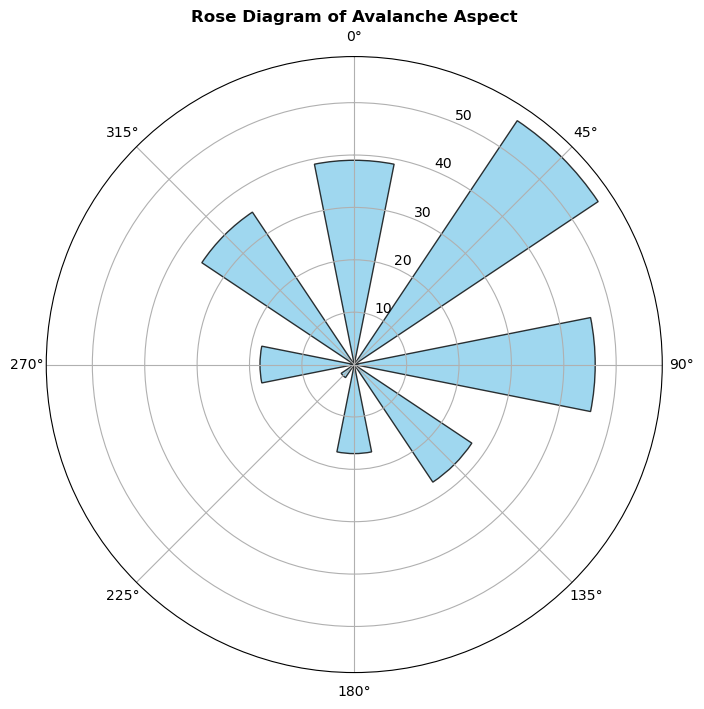

In [282]:
#Convert to radians
aspect_radians = np.deg2rad(avalanche_df['Aspect'])

#Make bins for every 22.5 degrees
num_bins = 16
bins = np.linspace(0, 2*np.pi, num_bins + 1)

counts, _ = np.histogram(aspect_radians, bins)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

bars = ax.bar(bins[:-1], counts, width=(2*np.pi/num_bins), bottom=0, color='skyblue', edgecolor='black', alpha=0.8)

ax.set_theta_zero_location('N')  # 0° at the top
ax.set_theta_direction(-1)       # Clockwise
ax.set_title("Rose Diagram of Avalanche Aspect", fontweight='bold')

plt.show()


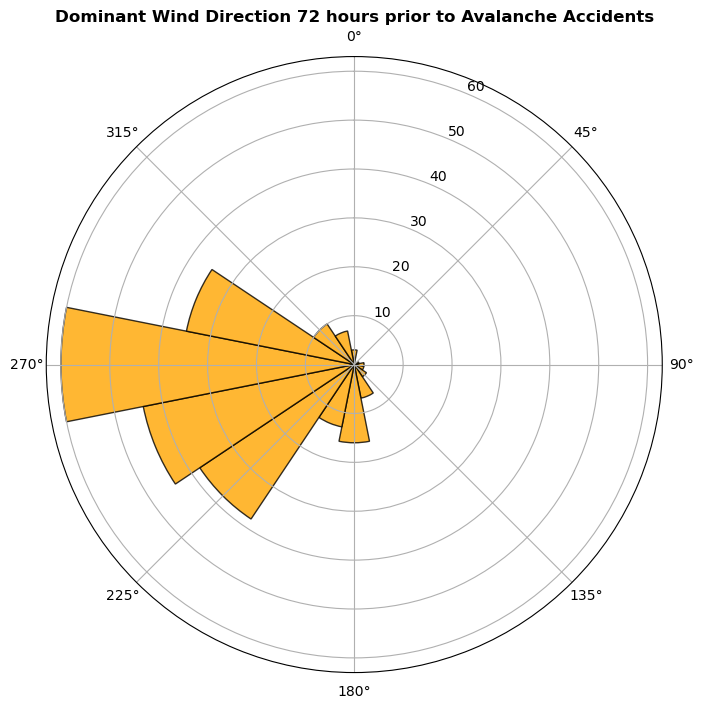

In [283]:
#Convert to radians
aspect_radians = np.deg2rad(avalanche_df['DominantWindDir_72h'])

#Make bins for every 22.5 degrees
num_bins = 16
bins = np.linspace(0, 2*np.pi, num_bins + 1)

counts, _ = np.histogram(aspect_radians, bins)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

bars = ax.bar(
    bins[:-1], 
    counts, 
    width=(2*np.pi/num_bins), 
    bottom=0, 
    color = "orange", 
    edgecolor='black', 
    alpha=0.8
)

ax.set_theta_zero_location('N')  # 0° at the top
ax.set_theta_direction(-1)       # Clockwise
ax.set_title("Dominant Wind Direction 72 hours prior to Avalanche Accidents", fontweight='bold')

plt.show()

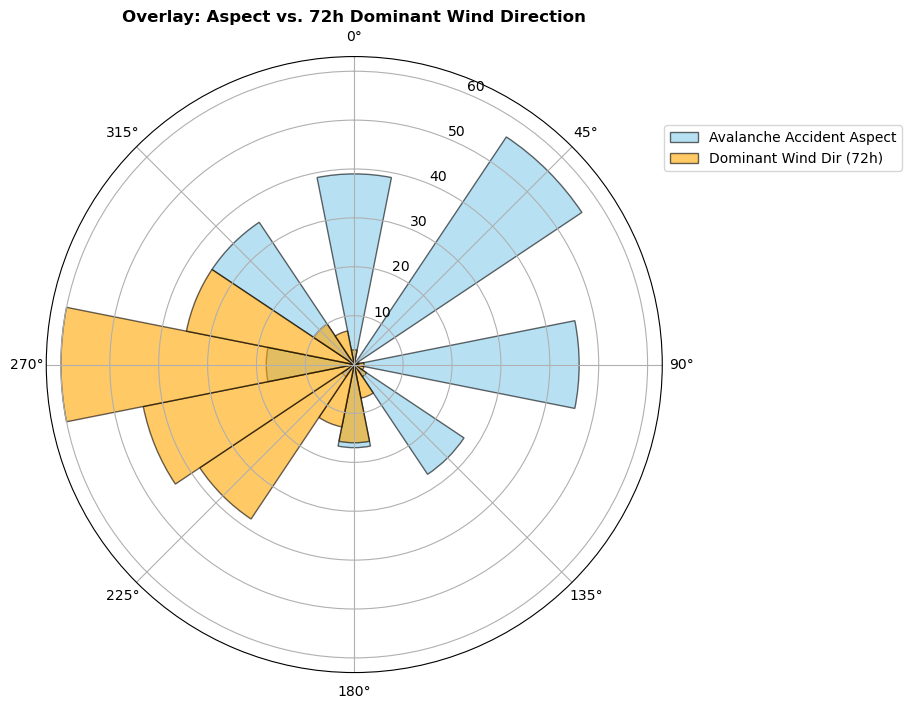

In [284]:
#This visualization uses the code from the previous rose plots and makes an overlay of aspect vs 72h wind direciton leading
#I previously didn't know how to make a rose plot but found this was one of the best ways to visualize directional data
#I had assitance from chatgpt to learn the syntax for writing rose plots

#start with radians conversion
aspect_radians = np.deg2rad(avalanche_df['Aspect'])
wind_radians = np.deg2rad(avalanche_df['DominantWindDir_72h'])

#use same bins from previous 2 visualizations
num_bins = 16
bins = np.linspace(0, 2*np.pi, num_bins + 1)

#histogram counts
aspect_counts, _ = np.histogram(aspect_radians, bins)
wind_counts, _ = np.histogram(wind_radians, bins)

#plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

#avalanche aspet bars
ax.bar(
    bins[:-1],
    aspect_counts,
    width=(2*np.pi/num_bins),
    bottom=0,
    color='skyblue',
    edgecolor='black',
    alpha=0.6,
    label="Avalanche Accident Aspect"
)

#wind direction bars
ax.bar(
    bins[:-1],
    wind_counts,
    width=(2*np.pi/num_bins),
    bottom=0,
    color='orange',
    edgecolor='black',
    alpha=0.6,
    label="Dominant Wind Dir (72h)"
)

ax.set_theta_zero_location('N')  
ax.set_theta_direction(-1)       
ax.set_title("Overlay: Aspect vs. 72h Dominant Wind Direction", fontweight='bold')
ax.legend(loc="upper right", bbox_to_anchor=(1.4, 0.9))

plt.show()

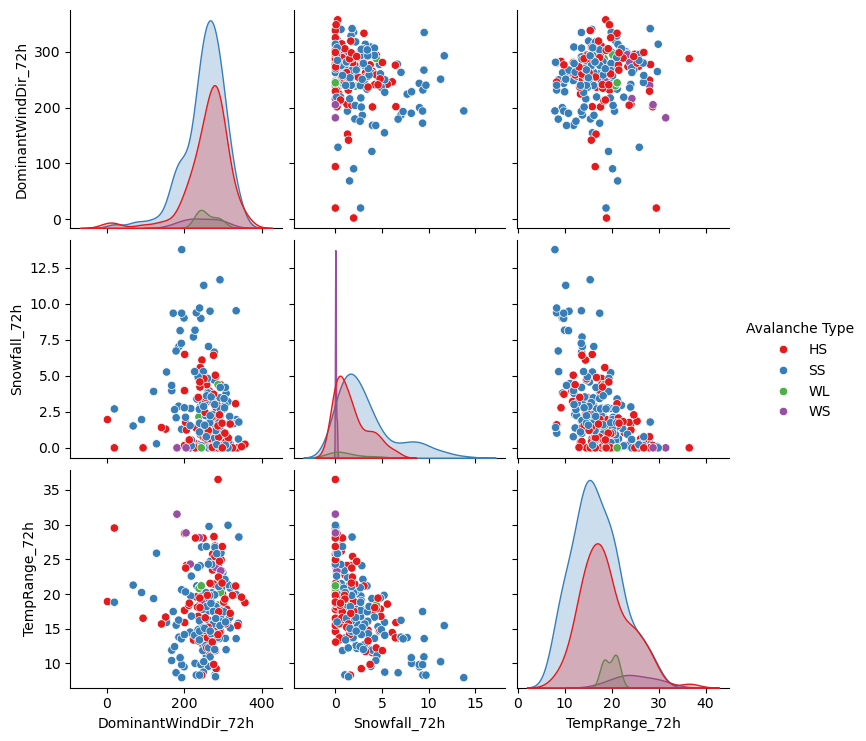

In [285]:
sns.pairplot(
    data=avalanche_df,
    vars=['DominantWindDir_72h', 'Snowfall_72h', 'TempRange_72h'],
    hue='Avalanche Type',
    palette='Set1',
    diag_kind='kde' 
)

In [290]:
#Create encoded dataframe

avalanche_df_encoded = pd.get_dummies(avalanche_df, columns = ['Season'], drop_first = True)

avalanche_df_encoded.head()

,Avalanche Type,Aspect,Elevation,Slope Degree,Snowfall_72h,AvgHighTemp_72h,AvgLowTemp_72h,AvgWindspeed_72h,DominantWindDir_72h,TempRange_72h,Season_Late Season,Season_Mid Season,Season_Off Season
0,HS,0,11400,37.5,3.97,17.20,-0.43,6.87,201.11,17.63,False,True,False
1,SS,45,11200,35.0,0.33,30.70,2.57,4.13,277.00,28.13,False,True,False
2,SS,270,12000,35.2,0.63,26.27,4.80,5.70,300.01,21.47,True,False,False
3,HS,270,11900,35.1,6.09,25.50,11.07,8.33,246.03,14.43,True,False,False
4,SS,90,11194,38.3,3.91,24.13,4.80,4.70,121.52,19.33,False,False,False


In [293]:
avalanche_df_encoded.columns

Index(['Avalanche Type', 'Aspect', 'Elevation', 'Slope Degree', 'Snowfall_72h',
       'AvgHighTemp_72h', 'AvgLowTemp_72h', 'AvgWindspeed_72h',
       'DominantWindDir_72h', 'TempRange_72h', 'Season_Late Season',
       'Season_Mid Season', 'Season_Off Season'],
      dtype='object')

In [323]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Y target:
y = avalanche_df_encoded['Avalanche Type']

#X features:
X = avalanche_df_encoded[['Aspect', 'Elevation', 'Slope Degree', 'Snowfall_72h',
       'AvgHighTemp_72h', 'AvgLowTemp_72h', 'AvgWindspeed_72h',
       'DominantWindDir_72h', 'TempRange_72h', 'Season_Late Season',
       'Season_Mid Season', 'Season_Off Season']]

#Create the splits. I chose to first try 70/30 to get a more stable and reliable performance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

rfc = RandomForestClassifier(n_estimators = 100, random_state=101)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=101)

In [324]:
rfc_pred = rfc.predict(X_test)

In [325]:
print(confusion_matrix(y_test, rfc_pred))

[[11 17  0  0]
 [ 8 33  0  0]
 [ 0  0  1  0]
 [ 0  1  1  1]]


In [326]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

          HS       0.58      0.39      0.47        28
          SS       0.65      0.80      0.72        41
          WL       0.50      1.00      0.67         1
          WS       1.00      0.33      0.50         3

    accuracy                           0.63        73
   macro avg       0.68      0.63      0.59        73
weighted avg       0.63      0.63      0.61        73



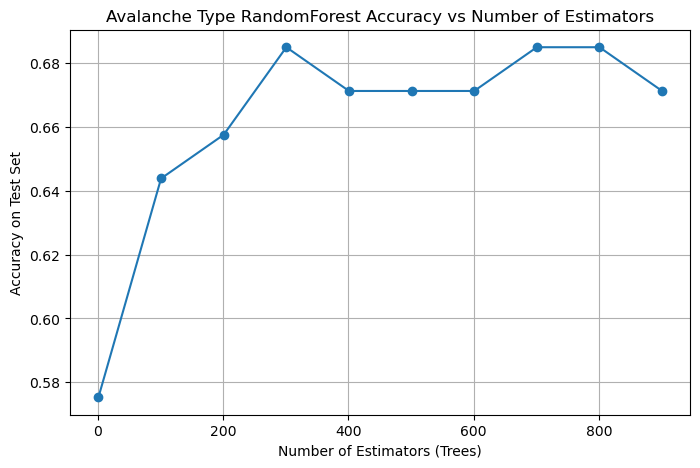

In [339]:
from sklearn.metrics import accuracy_score

estimator_range = range(1, 1000, 100) #A range from 0 to 1000 estimators in steps of 100
accuracies = [] #An empty list to hold accuracy percentage for each estimator

for e in estimator_range:
    rfc2 = RandomForestClassifier(n_estimators = e, class_weight = 'balanced', random_state = 101)
    rfc2.fit(X_train, y_train)
    rfc2_pred = rfc2.predict(X_test)
    accuracies.append(accuracy_score(y_test, rfc2_pred))

plt.figure(figsize = (8,5))
plt.plot(estimator_range, accuracies, marker ='o')
plt.xlabel("Number of Estimators (Trees)")
plt.ylabel("Accuracy on Test Set")
plt.title("Avalanche Type RandomForest Accuracy vs Number of Estimators")
plt.grid(True)
plt.show()

In [344]:
rfc3 = RandomForestClassifier(n_estimators = 300, class_weight = 'balanced', random_state = 101)
rfc3.fit(X_train, y_train)
rfc3_pred = rfc3.predict(X_test)

print(confusion_matrix(y_test, rfc3_pred))
print(classification_report(y_test,rfc3_pred))

[[12 16  0  0]
 [ 5 36  0  0]
 [ 0  0  1  0]
 [ 0  1  1  1]]
              precision    recall  f1-score   support

          HS       0.71      0.43      0.53        28
          SS       0.68      0.88      0.77        41
          WL       0.50      1.00      0.67         1
          WS       1.00      0.33      0.50         3

    accuracy                           0.68        73
   macro avg       0.72      0.66      0.62        73
weighted avg       0.70      0.68      0.66        73



In [353]:
print(avalanche_df_encoded['Avalanche Type'].value_counts())

Avalanche Type
SS    138
HS     88
WS      8
WL      7
Name: count, dtype: int64


In [357]:
#Trying out a 2 class model:

avalanche_df_encoded_2 = avalanche_df_encoded[~avalanche_df['Avalanche Type'].isin(['WL', 'WS'])]
avalanche_df_encoded_2 = avalanche_df_encoded_2.reset_index(drop=True)

rfc4 = RandomForestClassifier(n_estimators = 300, random_state = 101)
rfc4.fit(X_train, y_train)
rfc4_pred = rfc4.predict(X_test)
print(classification_report(y_test, rfc4_pred))

              precision    recall  f1-score   support

          HS       0.70      0.53      0.60        30
          SS       0.69      0.82      0.75        38

    accuracy                           0.69        68
   macro avg       0.69      0.67      0.68        68
weighted avg       0.69      0.69      0.68        68



                feature  importance
6      AvgWindspeed_72h    0.170944
3          Snowfall_72h    0.143708
1             Elevation    0.143266
2          Slope Degree    0.142123
4       AvgHighTemp_72h    0.088223
8         TempRange_72h    0.087453
5        AvgLowTemp_72h    0.082746
7   DominantWindDir_72h    0.078796
0                Aspect    0.040680
10    Season_Mid Season    0.010347
9    Season_Late Season    0.010329
11    Season_Off Season    0.001385


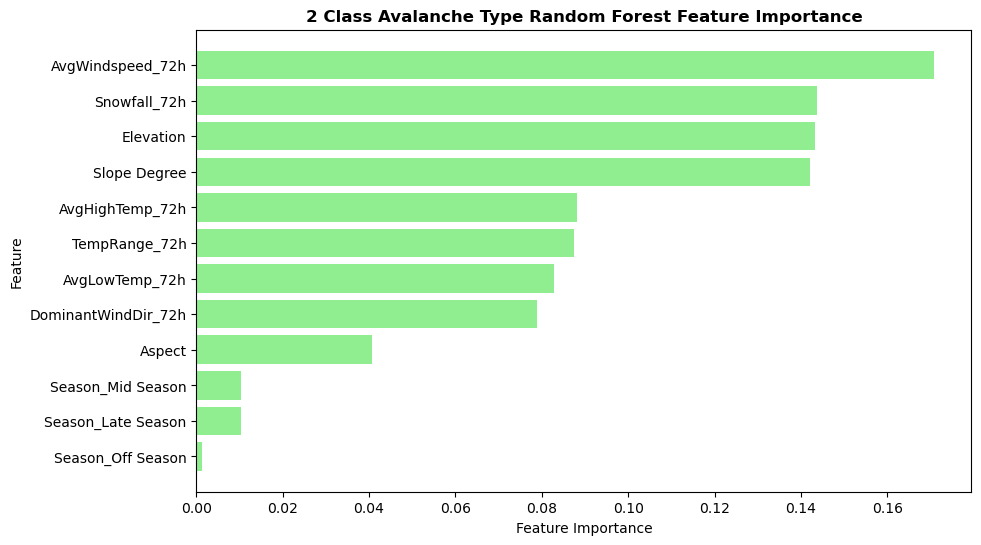

In [366]:
#feature importance analysis 

importances = rfc4.feature_importances_


feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color = 'lightgreen')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Avalanche Type Random Forest Feature Importance", weight = 'bold')
plt.gca().invert_yaxis()
plt.show()